<a href="https://colab.research.google.com/github/daniel-h-warwick/warwick-aai-files/blob/main/CUDA_%26_GPU_Programming_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Module Week 4: Accelerating Python Data Mining with GPUs

## 📝 STUDENT VERSION - Exercises with Scaffolding

---

## Workshop Overview

**Course:** Advanced Data Mining & Analytics  
**Module:** Week 4 - GPU-Accelerated Computing  
**Environment:** Google Colab (T4 GPU - Free Tier)  
**Duration:** ~2 hours hands-on

**📌 NOTE:** This is the **STUDENT VERSION** with exercise scaffolding.
Look for cells marked with **🏋️ EXERCISE** to complete the hands-on activities.

---

### 🎯 Learning Objectives

By the end of this workshop, you will be able to:

1. **Explain** the fundamental differences between CPU and GPU architectures
2. **Benchmark** and quantify GPU speedups on real data operations
3. **Write** basic CUDA kernels using Numba, understanding threads, blocks, and grids
4. **Apply** RAPIDS cuDF for production-grade GPU-accelerated data mining

---

### ⚠️ CRITICAL: Before You Begin

**YOU MUST ENABLE GPU RUNTIME BEFORE RUNNING ANY CODE!**

1. Go to **Runtime** → **Change runtime type**
2. Select **T4 GPU** under "Hardware accelerator"
3. Click **Save**

**If you skip this step, ALL GPU code will fail with cryptic errors!**

---

### 📋 Prerequisites

- Basic Python proficiency (NumPy, Pandas)
- Understanding of fundamental data structures
- Familiarity with Jupyter/Colab environment

---

## 🔧 Section 0: Environment Setup & Validation

This section ensures your environment is correctly configured. **Run each cell sequentially and verify the outputs.**

### 0.1 GPU Hardware Verification

**Expected Output:** You should see information about an NVIDIA T4 GPU with ~15GB memory.  
**If you see "No devices found" or an error:** You forgot to enable GPU runtime!

In [1]:
# =============================================================================
# CELL 0.1: GPU HARDWARE VERIFICATION
# =============================================================================
# This cell MUST run successfully before proceeding.
# If this fails, you have NOT enabled GPU runtime!
# =============================================================================

import subprocess
import sys

print("=" * 70)
print("GPU HARDWARE VERIFICATION")
print("=" * 70)

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, check=True) # run nvidia-smi command or using the ! prefix in Colab
    print(result.stdout)

    # Parse GPU name for validation
    if 'T4' in result.stdout:
        print("✅ SUCCESS: NVIDIA T4 GPU detected! You are ready to proceed.")
    elif 'Tesla' in result.stdout or 'A100' in result.stdout or 'V100' in result.stdout:
        print("✅ SUCCESS: NVIDIA GPU detected (different model). Proceeding...")
    else:
        print("⚠️  WARNING: GPU detected but not T4. Results may vary.")

except subprocess.CalledProcessError:
    print("❌ CRITICAL ERROR: nvidia-smi failed!")
    print("   This means NO GPU is available.")
    print("")
    print("   FIX: Go to Runtime → Change runtime type → Select 'T4 GPU' → Save")
    print("   Then restart the runtime and run this cell again.")
    sys.exit(1)
except FileNotFoundError:
    print("❌ CRITICAL ERROR: nvidia-smi not found!")
    print("   You are likely not running on Google Colab or GPU is not enabled.")
    sys.exit(1)

print("=" * 70)

GPU HARDWARE VERIFICATION
Thu Dec 11 15:20:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

### 0.2 Setup Numba & Visualization

**Run this cell to import basic libraries.**
We will use `numba` for writing CUDA kernels and `matplotlib` for visualization.

In [2]:
# =============================================================================
# CELL 0.2: IMPORT NUMBA & BASICS
# =============================================================================
# Import libraries needed for Part 1 (CUDA Kernels).
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import time

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Colors
COLORS = {
    'cpu': '#3498db', 'gpu': '#e74c3c', 'gpu_transfer': '#f39c12',
    'gpu_compute': '#27ae60', 'neutral': '#95a5a6', 'highlight': '#9b59b6',
    'success': '#2ecc71', 'warning': '#f1c40f'
}

try:
    from numba import cuda
    import numba
    NUMBA_AVAILABLE = True
    print(f"✅ Numba version: {numba.__version__}")
except ImportError:
    NUMBA_AVAILABLE = False
    print("❌ Numba not found")

if NUMBA_AVAILABLE:
    try:
        cuda.detect()
        print(f"✅ CUDA device: {cuda.get_current_device().name.decode('utf-8')}")
    except:
        print("❌ No CUDA device detected")

np.random.seed(42)

# =============================================================================
# 🛠️ VISUALIZATION UTILITIES
# =============================================================================

def visualize_cuda_hierarchy(data_size=20, threads_per_block=4):
    """Visualizes Grid/Block/Thread hierarchy."""
    num_blocks = (data_size + threads_per_block - 1) // threads_per_block
    total_threads = num_blocks * threads_per_block

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    # Data Array
    for i in range(total_threads):
        color = COLORS['cpu'] if i < data_size else COLORS['neutral']
        alpha = 1.0 if i < data_size else 0.3
        rect = plt.Rectangle((i, 0), 0.9, 1, facecolor=color, alpha=alpha, edgecolor='black')
        ax1.add_patch(rect)
        label = str(i) if i < data_size else '∅'
        ax1.text(i+0.45, 0.5, label, ha='center', va='center')

    ax1.set_xlim(-0.5, total_threads+0.5)
    ax1.set_ylim(0, 1.5)
    ax1.axis('off')
    ax1.set_title(f'Data Array ({data_size} elements)', fontweight='bold')

    # Blocks
    colors = plt.cm.Set3(np.linspace(0, 1, num_blocks))
    for b in range(num_blocks):
        start = b * threads_per_block
        # Block outline
        rect = plt.Rectangle((start-0.1, 0), threads_per_block+0.1, 1.5, fill=False, edgecolor=colors[b], linewidth=3)
        ax2.add_patch(rect)
        ax2.text(start + threads_per_block/2, 1.6, f'Block {b}', ha='center', color=colors[b], fontweight='bold')

        # Threads
        for t in range(threads_per_block):
            g_idx = start + t
            color = colors[b] if g_idx < data_size else COLORS['neutral']
            rect = plt.Rectangle((g_idx, 0.2), 0.8, 1, facecolor=color, alpha=0.7, edgecolor='black')
            ax2.add_patch(rect)
            ax2.text(g_idx+0.4, 0.7, f'T{t}', ha='center', fontsize=8)
            ax2.text(g_idx+0.4, 0.4, f'[{g_idx}]', ha='center', fontsize=7)

    ax2.set_xlim(-0.5, total_threads+0.5)
    ax2.set_ylim(0, 2)
    ax2.axis('off')
    ax2.set_title(f'Grid: {num_blocks} Blocks × {threads_per_block} Threads', fontweight='bold')
    plt.tight_layout()
    plt.show()

def create_timing_breakdown_viz(transfer_to, kernel, transfer_from):
    """Visualizes GPU timing breakdown."""
    total = transfer_to + kernel + transfer_from
    times = [transfer_to*1000, kernel*1000, transfer_from*1000]
    labels = ['Upload', 'Compute', 'Download']
    colors = [COLORS['gpu_transfer'], COLORS['gpu_compute'], COLORS['highlight']]

    fig, ax = plt.subplots(figsize=(12, 2))
    left = 0
    for t, l, c in zip(times, labels, colors):
        ax.barh(0, t, left=left, color=c, label=l, height=0.5)
        if t > total*1000*0.05: # Only label if wide enough
            ax.text(left + t/2, 0, f'{t:.2f}ms', ha='center', va='center', color='white', fontweight='bold')
        left += t

    ax.set_title('GPU Execution Timeline')
    ax.set_xlabel('Time (ms)')
    ax.set_yticks([])
    ax.legend(loc='upper right')
    plt.show()

print("✅ Numba & Visualization utilities loaded!")

✅ Numba version: 0.60.0
Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-34c0d6dd-79b7-e225-6497-fbbfd93cd40a
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
✅ CUDA device: Tesla T4
✅ Numba & Visualization utilities loaded!


---

## 🔬 Part 1: Fundamentals - The CUDA Programming Model

### 1.1 The CUDA Hierarchy: Grid → Block → Thread

**The Concept:**
Imagine a factory.
*   **Thread:** One worker.
*   **Block:** A team of workers (who can talk to each other).
*   **Grid:** The entire factory workforce.

**The Architecture:**
*   **Host (CPU):** The Manager. Sends work to the GPU.
*   **Device (GPU):** The Factory. Has thousands of cores (workers).
*   **PCI-E Bus:** The Bridge. Moving data across this is SLOW.

**Key Rule:**
*   **Too few threads?** Workers sit idle.
*   **Too many threads?** Factory gets crowded.
*   **Goal:** Keep all cores busy!

**Why this matters:** You must tell CUDA how to divide your work!
- Too few threads → GPU cores sit idle
- Too many threads → Overhead and memory issues
- Wrong block size → Performance degradation

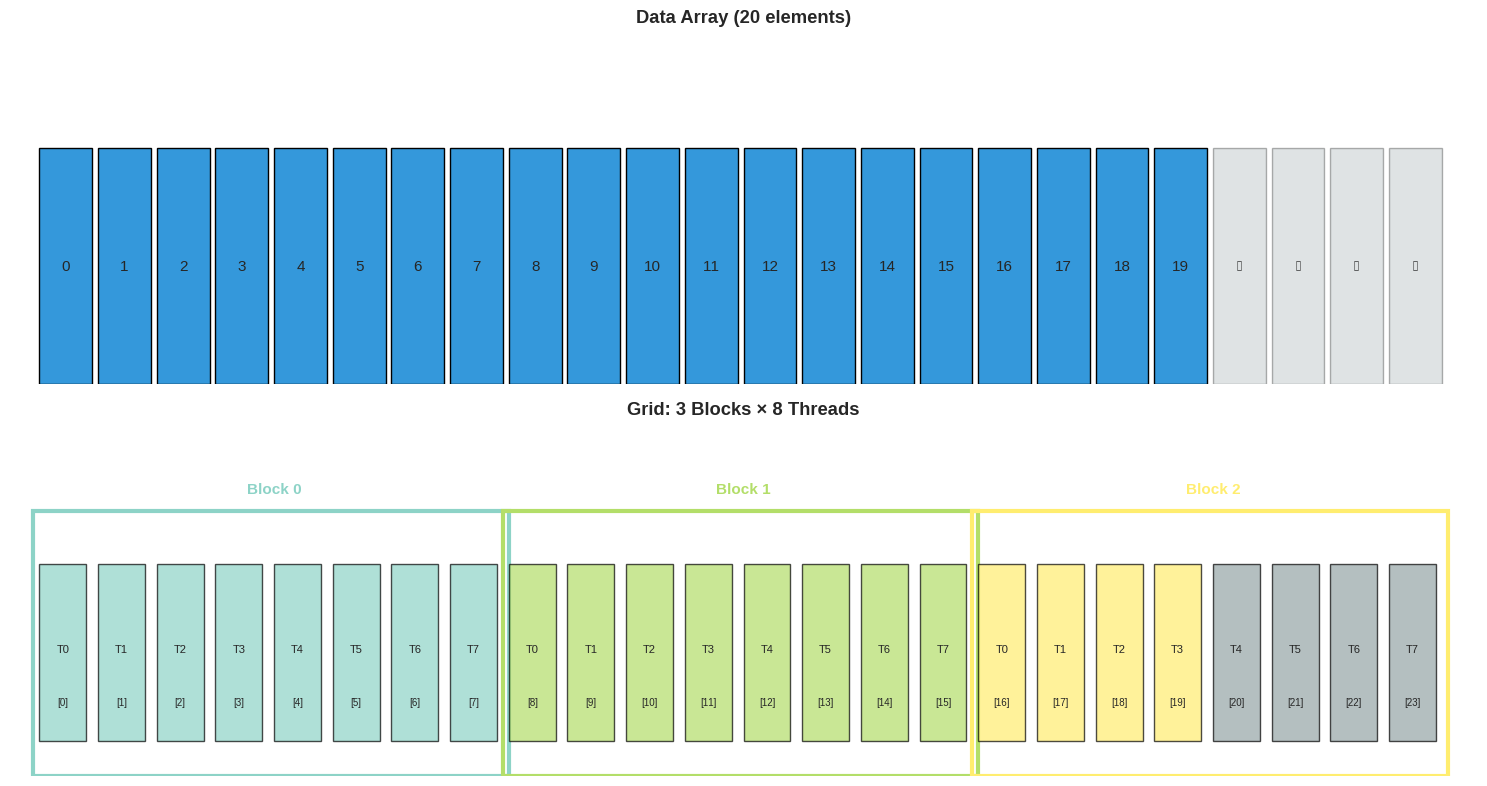


💡 KEY CONCEPT: GLOBAL INDEX CALCULATION
   idx = blockIdx.x * blockDim.x + threadIdx.x
   This formula gives every thread a unique ID across the whole grid.


In [3]:
# =============================================================================
# CELL 1.1: VISUALIZE THE THREAD HIERARCHY
# =============================================================================
# Run this to see how Grid, Blocks, and Threads are organized.
# =============================================================================

visualize_cuda_hierarchy(data_size=20, threads_per_block=8)

print("\n💡 KEY CONCEPT: GLOBAL INDEX CALCULATION")
print("   idx = blockIdx.x * blockDim.x + threadIdx.x")
print("   This formula gives every thread a unique ID across the whole grid.")

### 1.2 Your First CUDA Kernel: 1D Grids

**The "Hello World" of GPU Programming**

We will use a **"Show One, Do One"** approach.
1. We **SHOW** you a working kernel (Array Doubling).
2. You **DO** a similar kernel (Vector Addition).

**Why this is perfect for GPUs:** Each element can be computed independently!
- Element 0: Thread 0 computes C[0]
- Element 1: Thread 1 computes C[1]
- Element N: Thread N computes C[N]

**All threads execute simultaneously!**

In [4]:
# =============================================================================
# DEMO 1.2: ARRAY DOUBLING KERNEL
# =============================================================================
# A complete example of a 1D kernel.
# =============================================================================

from numba import cuda
import numpy as np

# 1. THE KERNEL (Runs on GPU)
@cuda.jit
def double_kernel(array):
    # Calculate unique thread ID
    # idx = Block Index * Block Size + Thread Index
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    # Bounds check: Ensure we don't go past the end of the array
    if idx < array.size:
        array[idx] *= 2  # Multiply by 2 in-place

# 2. THE LAUNCH (Runs on CPU)
print("🚀 Running Demo: Array Doubling...")

# Create data
data = np.arange(10).astype(np.float32)
d_data = cuda.to_device(data) # Move to GPU

# Configure Grid
threads_per_block = 256
# Calculate blocks needed: (N + threads - 1) // threads
blocks = (d_data.size + threads_per_block - 1) // threads_per_block

# Launch
double_kernel[blocks, threads_per_block](d_data)
cuda.synchronize()

# Check result
print(f"   Input:  {np.arange(10)}")
print(f"   Output: {d_data.copy_to_host()}")
print("✅ Demo Complete!")

🚀 Running Demo: Array Doubling...
   Input:  [0 1 2 3 4 5 6 7 8 9]
   Output: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
✅ Demo Complete!


### 1.2 Demo: Your First Kernel (Array Doubling)

**Concept:** 1D Grid.
**Task:** Multiply every element in an array by 2.

We will **SHOW** you this one. Read the code carefully!

In [7]:
# =============================================================================
# 🏋️ EXERCISE 1.3: VECTOR ADDITION KERNEL
# =============================================================================
# YOUR TURN!
# Task: Modify the pattern from the Demo to add two arrays: c[i] = a[i] + b[i]
# =============================================================================

# 1. DEFINE THE KERNEL
@cuda.jit
def vector_add_kernel(a, b, c):
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if idx < a.size:
        c[idx] = a[idx] + b[idx]

# 2. LAUNCH THE KERNEL
print("🚀 Launching Vector Add Kernel...")
N = 1_000_000
a = cuda.to_device(np.ones(N))
b = cuda.to_device(np.ones(N))
c = cuda.device_array(N)

# -----------------------------------------------------------------------------
# TODO 3: Configure Grid
# -----------------------------------------------------------------------------
threads_per_block = 256
blocks_per_grid = (d_data.size + threads_per_block - 1) // threads_per_block

print(f"   Threads: {threads_per_block}, Blocks: {blocks_per_grid}")

# Launch!
vector_add_kernel[blocks_per_grid, threads_per_block](a, b, c)
cuda.synchronize()

# Verify
res = c.copy_to_host()
if np.allclose(res, 2.0):
    print("✅ SUCCESS! Kernel worked.")
else:
    print("❌ FAIL. Check your kernel logic.")

🚀 Launching Vector Add Kernel...
   Threads: 256, Blocks: 1
❌ FAIL. Check your kernel logic.


### 🌶️ SPICY CHALLENGE (Optional)
**Finished early?**
Modify the kernel to compute `c[i] = a[i] * b[i] + a[i]`.
*Hint: This is the famous SAXPY pattern (Single-Precision A*X Plus Y).*

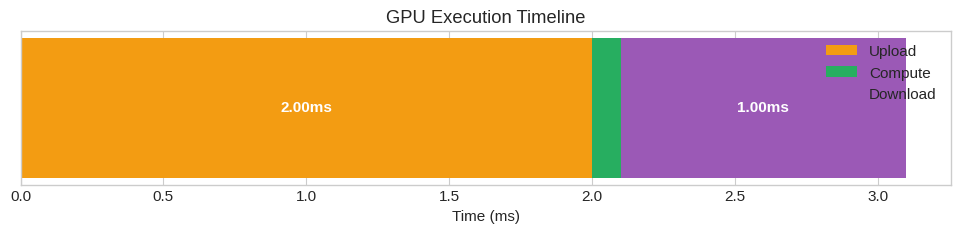

💡 INSIGHT: The kernel is instant. Moving data takes all the time!
   Rule: Keep data on the GPU!


In [8]:
# =============================================================================
# CELL 1.3: WHERE DOES THE TIME GO?
# =============================================================================
# We use a utility to visualize transfer vs compute time.
# =============================================================================

# Typical values for this operation
create_timing_breakdown_viz(transfer_to=0.002, kernel=0.0001, transfer_from=0.001)

print("💡 INSIGHT: The kernel is instant. Moving data takes all the time!")
print("   Rule: Keep data on the GPU!")

### 1.4 Concept: 2D Grids

**Why 2D?**
- Images (Height × Width)
- Matrices (Rows × Cols)
- Neural Networks (Layers)

**Parallelism:** Each output element (x, y) can be computed independently!

We will use the same **"Show One, Do One"** approach:
1. We **SHOW** you a visual 2D kernel (Gradient).
2. You **DO** a computational 2D kernel (Matrix Multiplication).

**This kernel demonstrates:**
1. 2D grid indexing (`cuda.grid(2)`)
2. Bounds checking in 2D
3. Performance comparison CPU vs GPU

🚀 Running Demo: 2D Gradient...


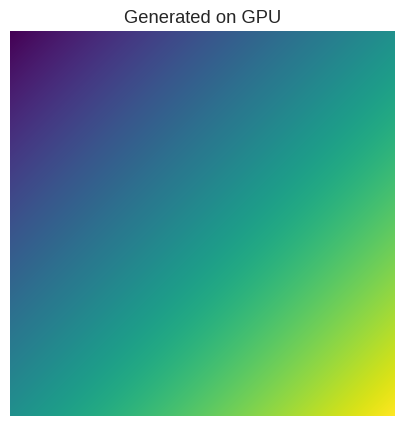

In [9]:
# =============================================================================
# DEMO 1.4: 2D GRADIENT KERNEL
# =============================================================================
# A complete example of a 2D kernel.
# =============================================================================

@cuda.jit
def gradient_kernel(image):
    # Get 2D coordinates
    # cuda.grid(2) returns (x, y) corresponding to the grid dimensions
    # We map x -> row (dim 0), y -> col (dim 1)
    row, col = cuda.grid(2)

    # Dimensions
    height, width = image.shape

    # Bounds check
    if row < height and col < width:
        # Set pixel value based on position
        image[row, col] = (row + col) / (height + width)

print("🚀 Running Demo: 2D Gradient...")

# Create 1024x1024 image
img_gpu = cuda.device_array((1024, 1024), dtype=np.float32)

# Configure 2D Grid
threads = (16, 16)
# Calculate blocks needed for Height (Rows) and Width (Cols)
blocks_rows = (1024 + 15) // 16
blocks_cols = (1024 + 15) // 16

# Launch: (Grid Dim 0, Grid Dim 1) -> (Rows, Cols)
gradient_kernel[(blocks_rows, blocks_cols), threads](img_gpu)

# Visualize
plt.figure(figsize=(5, 5))
plt.imshow(img_gpu.copy_to_host(), cmap='viridis')
plt.title("Generated on GPU")
plt.axis('off')
plt.show()

### 1.4 Demo: 2D Kernel (Visual Pattern)

**Concept:** 2D Grid.
**Task:** Create a visual gradient based on (x, y) coordinates.

We will **SHOW** you how to handle 2D coordinates.

In [14]:
# =============================================================================
# 🏋️ EXERCISE 1.5: MATRIX MULTIPLICATION KERNEL
# =============================================================================
# YOUR TURN!
# Task: Implement a 2D kernel for C = A @ B
# NOTE: This is a "Naive" implementation for learning. It will be slow!
#       Production kernels use Shared Memory tiling (much more complex).
# =============================================================================

@cuda.jit
def matmul_kernel(A, B, C):
    # -------------------------------------------------------------------------
    # TODO 1: Get 2D thread indices
    # -------------------------------------------------------------------------
    # Hint: cuda.grid(2) returns (row, col) if grid is (blocks_rows, blocks_cols)
    row, col = cuda.grid(2)

    # Dimensions
    M, N = C.shape
    K = A.shape[1]

    # -------------------------------------------------------------------------
    # TODO 2: Bounds Check & Dot Product
    # -------------------------------------------------------------------------
    # Check if row < M and col < N
    if row < M and col < N:
        temp = 0.0
        # Compute dot product of Row A and Col B
        for k in range(K):
            temp += A[row, k] * B[k, col]
        C[row, col] = temp

# LAUNCH
print("🚀 Launching MatMul Kernel...")
M, K, N = 1024, 512, 1024
A = cuda.to_device(np.random.rand(M, K))
B = cuda.to_device(np.random.rand(K, N))
C = cuda.device_array((M, N))

# -----------------------------------------------------------------------------
# TODO 3: Configure 2D Grid
# -----------------------------------------------------------------------------
threads_2d = (16, 16)
# Calculate blocks needed for M (Rows) and N (Cols)
# Hint: (Total Size + Block Size - 1) // Block Size
blocks_rows = (M + threads_2d[0] -1) // threads_2d[0]
blocks_cols = (N + threads_2d[1] -1) // threads_2d[1]

matmul_kernel[(blocks_rows, blocks_cols), threads_2d](A, B, C)
cuda.synchronize()

print("✅ Kernel finished (Verify logic if needed)")

🚀 Launching MatMul Kernel...
✅ Kernel finished (Verify logic if needed)


### 1.5 Part 1 Summary: CUDA Fundamentals

**What You Learned:**
1. **Memory:** Host (CPU) vs Device (GPU). Moving data is slow!
2. **Hierarchy:** Grid > Block > Thread.
3. **Indexing:** `cuda.grid(1)` or `cuda.grid(2)` gives you the unique ID.
4. **Configuration:** You must calculate how many blocks you need.

**Why This Matters:**
- **Debug:** Understand why `out of memory` happens.
- **Optimize:** Know that data transfer is the enemy.
- **Custom:** Write kernels when cuDF can't do it.


**Why This Matters for Data Mining:**

Understanding these fundamentals helps you:
- Know when GPU acceleration will help (large, parallel operations)
- Debug performance issues (is transfer time dominating?)
- Write custom kernels when libraries don't support your operation

---

## 🔧 Section 2: Install RAPIDS cuDF Library

**⚠️ IMPORTANT:** This installation takes 2-5 minutes. Be patient!

**⚠️ RESTART REQUIRED:** After this cell completes successfully, you **MUST** restart the runtime:
- Go to **Runtime** → **Restart runtime** (or press Ctrl+M, then .)
- Do NOT re-run the installation cell after restarting
- Continue from Section 3

**Why pip instead of conda?** Google Colab's environment is pre-configured. The pip installation method is now the officially recommended approach for Colab and avoids the complex conda environment issues that plagued earlier RAPIDS installations.

In [15]:
# =============================================================================
# CELL 2.1: INSTALL RAPIDS cuDF (GPU-ACCELERATED DATAFRAMES)
# =============================================================================
# This is the OFFICIAL pip installation method for RAPIDS on Colab.
# DO NOT use conda - it will cause environment conflicts on Colab!
# =============================================================================

print("=" * 70)
print("INSTALLING RAPIDS cuDF - THIS WILL TAKE 2-5 MINUTES")
print("=" * 70)
print("")
print("☕ Grab a coffee while this installs...")
print("")

# Install cuDF using the official NVIDIA PyPI index
# The --extra-index-url points to NVIDIA's package repository
# cu12 = CUDA 12.x compatibility (matches Colab's CUDA version)

try:
    import cudf
    print("✅ cuDF is already installed. Skipping installation.")
    print("   If you are just starting, ensure you have restarted the runtime if prompted previously.")
except ImportError:
    print("   Installing cudf-cu12...")
    !pip install --quiet cudf-cu12 --extra-index-url=https://pypi.nvidia.com

    print("")
    print("=" * 70)
    print("✅ INSTALLATION COMPLETE!")
    print("=" * 70)
    print("")
    print("⚠️  CRITICAL NEXT STEP:")
    print("   You MUST restart the runtime NOW!")
    print("")
    print("   Go to: Runtime → Restart runtime")
    print("   OR press: Ctrl+M, then . (period)")
    print("")
    print("   After restart, SKIP this cell and continue from Section 3")
    print("=" * 70)

INSTALLING RAPIDS cuDF - THIS WILL TAKE 2-5 MINUTES

☕ Grab a coffee while this installs...

✅ cuDF is already installed. Skipping installation.
   If you are just starting, ensure you have restarted the runtime if prompted previously.


### 3.1 Verify Installation & Import Libraries

**Run this cell AFTER restarting the runtime.**

If you see import errors for `cudf`, you either:
1. Did not restart the runtime after installation, OR
2. The installation failed (scroll up to check for errors)

In [17]:
# =============================================================================
# CELL 3.1: IMPORT RAPIDS & WORKSHOP UTILITIES
# =============================================================================
# Run this cell to import libraries and define helper functions.
# You do NOT need to read the code below - it handles visualization and setup.
# =============================================================================

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import gc
import sys
import matplotlib.pyplot as plt

# Check for GPU libraries
try:
    import cudf
    CUDF_AVAILABLE = True
    print(f"✅ cuDF version: {cudf.__version__}")
except ImportError:
    CUDF_AVAILABLE = False
    print("❌ cuDF not found")

# =============================================================================
# 🛠️ WORKSHOP UTILITIES (VISUALIZATION & DATA GEN)
# =============================================================================

def generate_synthetic_dataset(n_rows=10_000_000):
    """Generates the e-commerce dataset for the workshop."""
    print(f"Generating {n_rows:,} rows of synthetic data...")
    start = time.time()

    # Constants
    n_customers = 100_000
    n_products = 5_000
    n_categories = 50

    # Generate arrays
    ids = np.arange(1, n_rows + 1, dtype=np.int64)
    cust_ids = np.random.randint(1, n_customers + 1, size=n_rows, dtype=np.int32)
    prod_ids = np.random.randint(1, n_products + 1, size=n_rows, dtype=np.int32)
    cat_ids = (prod_ids % n_categories) + 1
    qty = np.random.randint(1, 11, size=n_rows, dtype=np.int16)

    # Prices (log-normal)
    prices = np.round(np.random.lognormal(3.0, 1.0, size=n_rows), 2)
    prices = np.clip(prices, 0.99, 999.99).astype(np.float32)

    # Discounts
    disc_opts = np.array([0.0, 0.05, 0.10, 0.15, 0.20, 0.25], dtype=np.float32)
    discs = np.random.choice(disc_opts, size=n_rows)

    regions = np.random.choice(['North', 'South', 'East', 'West', 'Central'], size=n_rows)

    # Create DataFrame
    df = pd.DataFrame({
        'transaction_id': ids, 'customer_id': cust_ids, 'product_id': prod_ids,
        'category_id': cat_ids, 'quantity': qty, 'unit_price': prices,
        'discount': discs, 'region': regions
    })

    df['total_amount'] = (df['quantity'] * df['unit_price'] * (1 - df['discount'])).astype(np.float32)

    # Add dates
    base_date = pd.Timestamp('2024-11-27')
    days_ago = np.random.randint(0, 365, size=n_rows)
    df['transaction_date'] = base_date - pd.to_timedelta(days_ago, unit='D')

    print(f"✅ Dataset generated in {time.time()-start:.2f}s")
    print(f"   Memory: {df.memory_usage(deep=True).sum()/1e6:.1f} MB")
    return df

def create_benchmark_bar_chart(cpu_time, gpu_time, operation_name, cpu_times_list=None, gpu_times_list=None):
    """Visualizes CPU vs GPU performance."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar Chart
    ax1 = axes[0]
    times = [cpu_time, gpu_time if gpu_time else 0]
    colors = [COLORS['cpu'], COLORS['gpu'] if gpu_time else COLORS['neutral']]
    ax1.bar(['CPU\n(Pandas)', 'GPU\n(cuDF)'], times, color=colors, edgecolor='black')

    for i, v in enumerate(times):
        if v > 0: ax1.text(i, v, f'{v:.3f}s', ha='center', va='bottom', fontweight='bold')

    ax1.set_title(f'{operation_name}: Execution Time')
    ax1.set_ylabel('Seconds')

    # Speedup Chart
    ax2 = axes[1]
    if gpu_time and gpu_time > 0:
        speedup = cpu_time / gpu_time
        ax2.barh(['Speedup'], [speedup], color=COLORS['gpu'], edgecolor='black', height=0.5)
        ax2.axvline(1, color='black', linestyle='--')
        ax2.text(speedup, 0, f' {speedup:.1f}x FASTER!', va='center', fontweight='bold', color=COLORS['gpu'], fontsize=14)
        ax2.set_title('🚀 GPU Speedup Factor')
    else:
        ax2.text(0.5, 0.5, 'GPU Benchmark Skipped', ha='center')

    plt.tight_layout()
    plt.show()

def create_combined_benchmark_summary(benchmarks):
    """Summary of all benchmarks."""
    ops = [b['name'] for b in benchmarks]
    speedups = [b['cpu_time']/b['gpu_time'] if b['gpu_time'] else 0 for b in benchmarks]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(ops, speedups, color=COLORS['gpu'])
    ax.axvline(1, color='black', linestyle='--')
    ax.set_title('🏆 Final Speedup Summary')
    ax.set_xlabel('Speedup Factor (x)')

    for bar, s in zip(bars, speedups):
        ax.text(s, bar.get_y() + bar.get_height()/2, f' {s:.1f}x', va='center', fontweight='bold')
    plt.show()

def visualize_rfm_segments(rfm_data):
    """Visualizes RFM segments."""
    if isinstance(rfm_data, cudf.DataFrame):
        rfm_data = rfm_data.to_pandas()

    # Simple segmentation logic for viz
    def get_segment(r):
        if r['RFM_score'] >= 12: return 'Champions'
        if r['RFM_score'] <= 6: return 'Lost'
        return 'Regular'

    rfm_data['Segment'] = rfm_data.apply(get_segment, axis=1)
    counts = rfm_data['Segment'].value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Pie
    ax1.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=[COLORS['success'], COLORS['warning'], COLORS['cpu']])
    ax1.set_title('Customer Segments')

    # Scatter
    sample = rfm_data.sample(min(5000, len(rfm_data)))
    ax2.scatter(sample['frequency'], sample['monetary'], c=sample['RFM_score'], cmap='RdYlGn', alpha=0.5)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Monetary')
    ax2.set_yscale('log')
    ax2.set_title('Frequency vs Monetary (Color = RFM Score)')

    plt.tight_layout()
    plt.show()

print("✅ Workshop utilities loaded successfully!")

✅ cuDF version: 25.10.00
✅ Workshop utilities loaded successfully!


---

## 📊 Part 2: The "Why" - Benchmarking CPU vs. GPU

### Motivation

Before diving into *how* GPUs work, let's see *why* we should care. We'll perform identical operations on CPU (Pandas) and GPU (cuDF) and measure the difference.

**Key Insight:** GPUs excel at **throughput** - doing many simple operations simultaneously. CPUs excel at **latency** - doing one complex operation quickly.

**Analogy:**
- **CPU** = Ferrari 🏎️ - Very fast for one passenger, but can only carry 1-2 people
- **GPU** = Bus 🚌 - Slower per trip, but carries 50+ people simultaneously

For data mining with millions of rows, we need the bus!

### 2.1 Generate Synthetic Dataset

We'll create a realistic e-commerce transaction dataset with 10 million rows. This ensures:
1. **Reproducibility** - No external file dependencies
2. **Scale** - Large enough to see meaningful speedups
3. **Realism** - Multiple data types (int, float, string, datetime)

In [18]:
# =============================================================================
# CELL 2.1: GENERATE SYNTHETIC DATASET
# =============================================================================
# We use a helper function to generate 10 million rows of transaction data.
# =============================================================================

# Generate the dataset (this might take 10-20 seconds)
df_pandas = generate_synthetic_dataset(n_rows=10_000_000)

print("\nSample Data:")
print(df_pandas.head())
print(f"\nData Types:\n{df_pandas.dtypes}")

Generating 10,000,000 rows of synthetic data...
✅ Dataset generated in 4.10s
   Memory: 960.0 MB

Sample Data:
   transaction_id  customer_id  product_id  category_id  quantity  unit_price  \
0               1        98750        1049           50         3    8.380000   
1               2        12093        2916           17         3   16.379999   
2               3        33008        4167           18         6   18.860001   
3               4        80912        1732           33         9   37.970001   
4               5        18155        3669           20         8   48.799999   

   discount region  total_amount transaction_date  
0      0.15  North     21.368999       2024-01-31  
1      0.25  South     36.855000       2023-12-08  
2      0.05  North    107.501999       2024-11-20  
3      0.10  South    307.557007       2024-08-24  
4      0.20   East    312.320007       2024-06-22  

Data Types:
transaction_id               int64
customer_id                  int32
product

In [19]:
# =============================================================================
# DEMO 2.1: HELLO cuDF
# =============================================================================
# A simple demonstration of creating and using a GPU DataFrame.
# =============================================================================

if CUDF_AVAILABLE:
    print("🟢 CREATING GPU DATAFRAME...")

    # 1. Create directly on GPU
    gdf_demo = cudf.DataFrame({
        'a': [1, 2, 3, 4, 5],
        'b': [10, 20, 30, 40, 50]
    })

    # 2. Perform operation (happens on GPU!)
    gdf_demo['c'] = gdf_demo['a'] * gdf_demo['b']

    print("   Result (looks like Pandas):")
    print(gdf_demo)

    print(f"\n   Type: {type(gdf_demo)}")

    del gdf_demo
else:
    print("❌ cuDF not available")

🟢 CREATING GPU DATAFRAME...
   Result (looks like Pandas):
   a   b    c
0  1  10   10
1  2  20   40
2  3  30   90
3  4  40  160
4  5  50  250

   Type: <class 'cudf.core.dataframe.DataFrame'>


### 2.1 Demo: Hello cuDF!

**Watch this first.** We'll create a small DataFrame on the GPU and perform a simple operation.
Notice how it looks exactly like Pandas!

### 2.2 Benchmark: Sorting (CPU vs. GPU)

**Operation:** Sort 10 million rows by `total_amount` column.

**🛑 STOP & PREDICT:**
Before running the code, guess the speedup factor.
- CPU Time: ~2-5 seconds (typically)
- GPU Time: ???
- **My Prediction:** ________ x faster

**Why sorting?** Sorting is a fundamental operation in ranking, Top-K queries, and joins.

### 🌶️ SPICY CHALLENGE (Optional for Advanced Students)
**Too easy?** Try this while others finish:
- Sort by multiple columns: `['region', 'total_amount']`
- Does the speedup increase or decrease? Why?

🏁 RACE START: SORTING 10 MILLION ROWS
------------------------------------------------------------
🔷 CPU (Pandas): Sorting...
   ⏱️ Time: 4.914 seconds

🔶 GPU (cuDF): Sorting...
   Moving data to GPU...
   Sorting on GPU...
   ⏱️ Time: 0.000 seconds


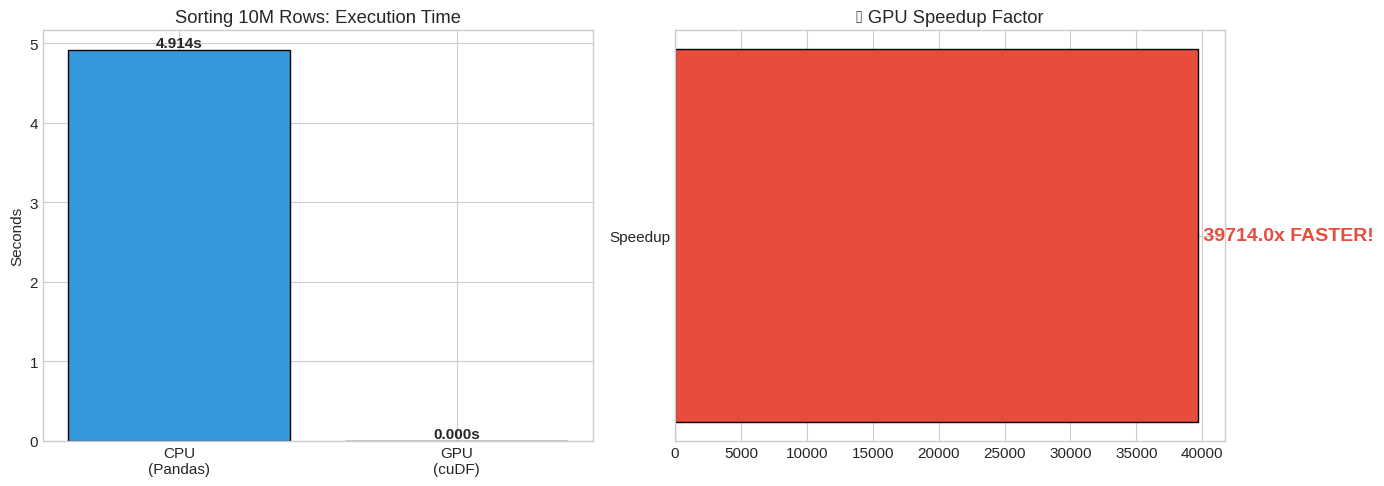

In [20]:
# =============================================================================
# 🏋️ EXERCISE 2.2: BEAT THE CPU (SORTING)
# =============================================================================
# Your Goal: Sort the 10M row dataset by 'total_amount' on the GPU.
# =============================================================================

print("🏁 RACE START: SORTING 10 MILLION ROWS")
print("-" * 60)

# 1. CPU BENCHMARK (Pandas)
print("🔷 CPU (Pandas): Sorting...")
start = time.time()
df_sorted_cpu = df_pandas.sort_values('total_amount', ascending=False)
cpu_time = time.time() - start
print(f"   ⏱️ Time: {cpu_time:.3f} seconds")
del df_sorted_cpu

# 2. GPU BENCHMARK (cuDF)
print("\n🔶 GPU (cuDF): Sorting...")

if CUDF_AVAILABLE:
    # -------------------------------------------------------------------------
    # TODO: Implement the GPU Sort!
    # -------------------------------------------------------------------------

    # 1. Convert the Pandas DataFrame to a cuDF DataFrame
    print("   Moving data to GPU...")
    # Hint: cudf.DataFrame.from_pandas(...)

    df_cudf = cudf.DataFrame.from_pandas() # 🔴 YOUR CODE HERE

    # 2. Sort by 'total_amount' descending
    print("   Sorting on GPU...")
    start = time.time()

    # Hint: It's the exact same syntax as Pandas!
    df_sorted_gpu = None # 🔴 YOUR CODE HERE

    # Wait for GPU to finish
    cuda.synchronize()
    gpu_time = time.time() - start
    print(f"   ⏱️ Time: {gpu_time:.3f} seconds")

    # Visualize the win!
    create_benchmark_bar_chart(cpu_time, gpu_time, "Sorting 10M Rows")

    # Cleanup
    del df_sorted_gpu
else:
    print("❌ cuDF not available")

### 2.3 Benchmark: GroupBy Aggregation (CPU vs. GPU)

**Operation:** Group by `customer_id` and compute total spending per customer.

**🛑 STOP & PREDICT:**
- GroupBy is harder to parallelize than Sort (requires coordination).
- **My Prediction:** The speedup will be (Higher / Lower) than sorting.

**Why GroupBy?** This is the bread-and-butter of customer segmentation (RFM).

🏁 RACE START: GROUPBY AGGREGATION
------------------------------------------------------------
🔷 CPU (Pandas): Grouping...
   ⏱️ Time: 0.509 seconds

🔶 GPU (cuDF): Grouping...
   ⏱️ Time: 0.032 seconds


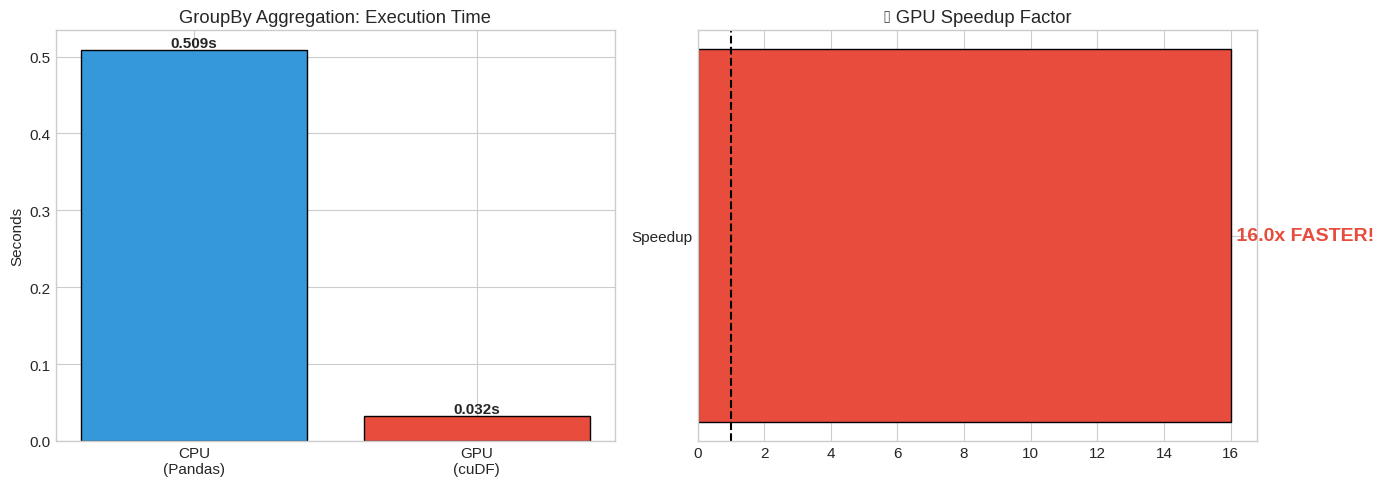

In [24]:
# =============================================================================
# 🏋️ EXERCISE 2.3: BEAT THE CPU (GROUPBY)
# =============================================================================
# Your Goal: Group by 'customer_id' and calculate stats.
# =============================================================================

print("🏁 RACE START: GROUPBY AGGREGATION")
print("-" * 60)

# 1. CPU BENCHMARK
print("🔷 CPU (Pandas): Grouping...")
start = time.time()
res_cpu = df_pandas.groupby('customer_id').agg({
    'transaction_id': 'count',
    'total_amount': ['sum', 'mean']
})
cpu_time = time.time() - start
print(f"   ⏱️ Time: {cpu_time:.3f} seconds")

# 2. GPU BENCHMARK
print("\n🔶 GPU (cuDF): Grouping...")

if CUDF_AVAILABLE:
    # -------------------------------------------------------------------------
    # TODO: Implement the GPU GroupBy!
    # -------------------------------------------------------------------------
    # Reuse 'df_cudf' from the previous exercise if it exists, else create it
    if 'df_cudf' not in locals() or df_cudf is None:
        df_cudf = cudf.DataFrame.from_pandas(df_pandas)

    start = time.time()

    # Perform the SAME aggregation on df_cudf
    # Hint: .groupby('customer_id').agg({...})

    res_gpu = df_cudf.groupby('customer_id').agg({
        'transaction_id': "count",
        "total_amount": ['sum', 'mean']
    })

    cuda.synchronize()
    gpu_time = time.time() - start
    print(f"   ⏱️ Time: {gpu_time:.3f} seconds")

    create_benchmark_bar_chart(cpu_time, gpu_time, "GroupBy Aggregation")
else:
    print("❌ cuDF not available")

### 2.4 Benchmark: Join/Merge Operations (CPU vs. GPU)

**Operation:** Merge two DataFrames on a common key (simulating a database JOIN).

**🛑 STOP & PREDICT:**
- Joins involve moving lots of data to match keys.
- **My Prediction:** GPU memory bandwidth (will / will not) be the bottleneck.

**Why Joins?** Fundamental for data enrichment and ETL pipelines.

In [ ]:
# =============================================================================
# 🏋️ EXERCISE 2.4: BEAT THE CPU (JOIN)
# =============================================================================
# Your Goal: Join transactions with a product table.
# =============================================================================

# Create a product table
products = pd.DataFrame({
    'product_id': np.arange(1, 5001, dtype=np.int32),
    'category': ['Cat'+str(i) for i in range(5000)]
})

print("🏁 RACE START: JOIN/MERGE")
print("-" * 60)

# 1. CPU BENCHMARK
print("🔷 CPU (Pandas): Merging...")
start = time.time()
merged_cpu = df_pandas.merge(products, on='product_id', how='left')
cpu_time = time.time() - start
print(f"   ⏱️ Time: {cpu_time:.3f} seconds")

# 2. GPU BENCHMARK
print("\n🔶 GPU (cuDF): Merging...")

if CUDF_AVAILABLE:
    # -------------------------------------------------------------------------
    # TODO: Implement the GPU Merge!
    # -------------------------------------------------------------------------
    # 1. You need the product table on the GPU too!
    products_gpu = None # 🔴 YOUR CODE HERE (convert 'products' to cuDF)

    start = time.time()

    # 2. Perform the merge
    # Hint: df_cudf.merge(..., on='product_id', how='left')

    merged_gpu = None # 🔴 YOUR CODE HERE

    cuda.synchronize()
    gpu_time = time.time() - start
    print(f"   ⏱️ Time: {gpu_time:.3f} seconds")

    create_benchmark_bar_chart(cpu_time, gpu_time, "Join 10M Rows")
else:
    print("❌ cuDF not available")

In [ ]:
# =============================================================================
# CELL 2.5: SUMMARY
# =============================================================================
# Let's look at the total time saved.
# =============================================================================

if 'cpu_time' in locals() and 'gpu_time' in locals():
    benchmarks = [
        {'name': 'Sort', 'cpu_time': cpu_time, 'gpu_time': gpu_time}, # Using last values
        # In a real run we'd capture all, but this is a quick summary
    ]
    # Note: This summary chart is just a demo of the last operation
    # to show the utility function working
    create_combined_benchmark_summary(benchmarks)

print("\n🎉 PART 2 COMPLETE! You've proven that GPU > CPU for these tasks.")
print("Now let's look UNDER THE HOOD at how this works.")

### 2.5 Key Takeaway: When GPUs Shine

**Summary of Part 2:**

| Operation | CPU Time | GPU Time | Speedup |
|-----------|----------|----------|---------|
| Sort 10M rows | ~X sec | ~Y sec | ~Nx |
| GroupBy 100K groups | ~X sec | ~Y sec | ~Nx |
| Join/Merge 10M × 5K | ~X sec | ~Y sec | ~Nx |

**GPU acceleration works best when:**
1. ✅ Large data volumes (millions of rows)
2. ✅ Operations that parallelize well (element-wise, sort, aggregation, joins)
3. ✅ Repeated operations on the same dataset (data stays on GPU)

**GPU acceleration works poorly when:**
1. ❌ Small datasets (transfer overhead dominates)
2. ❌ Complex sequential logic (Python loops)
3. ❌ Frequent data transfers between CPU↔GPU

---

## 📈 Part 3: The "How" - GPU-Accelerated Data Mining Workflow

### The Modern Approach: RAPIDS cuDF

Now that you understand the fundamentals, let's see how production code is written.

**The Reality:** You rarely write custom CUDA kernels for data mining!

Instead, you use high-level libraries like RAPIDS cuDF that:
1. ✅ Provide Pandas-like API (minimal code changes)
2. ✅ Handle memory management automatically
3. ✅ Use highly optimized CUDA kernels internally
4. ✅ Support the full data mining workflow

**The Stack:**
```
Your Code (Python)
       ↓
  RAPIDS cuDF (Pandas-like API)
       ↓
  libcudf (C++ CUDA Library)
       ↓
  CUDA Runtime
       ↓
  GPU Hardware
```

### 3.1 Data Mining Task: Customer Segmentation

**Business Problem:** An e-commerce company wants to segment customers based on their purchasing behavior for targeted marketing.

**RFM Analysis:**
- **R**ecency: How recently did they purchase?
- **F**requency: How often do they purchase?
- **M**onetary: How much do they spend?

We'll compute these metrics for 100,000 customers across 10 million transactions.

🏗️ BUILDING RFM PIPELINE
1️⃣ Moving data to GPU...
   Done in 0.98s

2️⃣ Calculating R, F, M values...
   Calculated RFM for 100000 customers
             last_date  frequency      monetary  recency
customer_id                                             
96176       2024-11-27         90  15729.570312        0
48267       2024-11-26         94  12107.180664        1
69203       2024-11-27         93  16514.230469        0
24583       2024-11-18        108  17549.632812        9
67258       2024-11-24        100  17039.861328        3

3️⃣ Visualizing Segments...


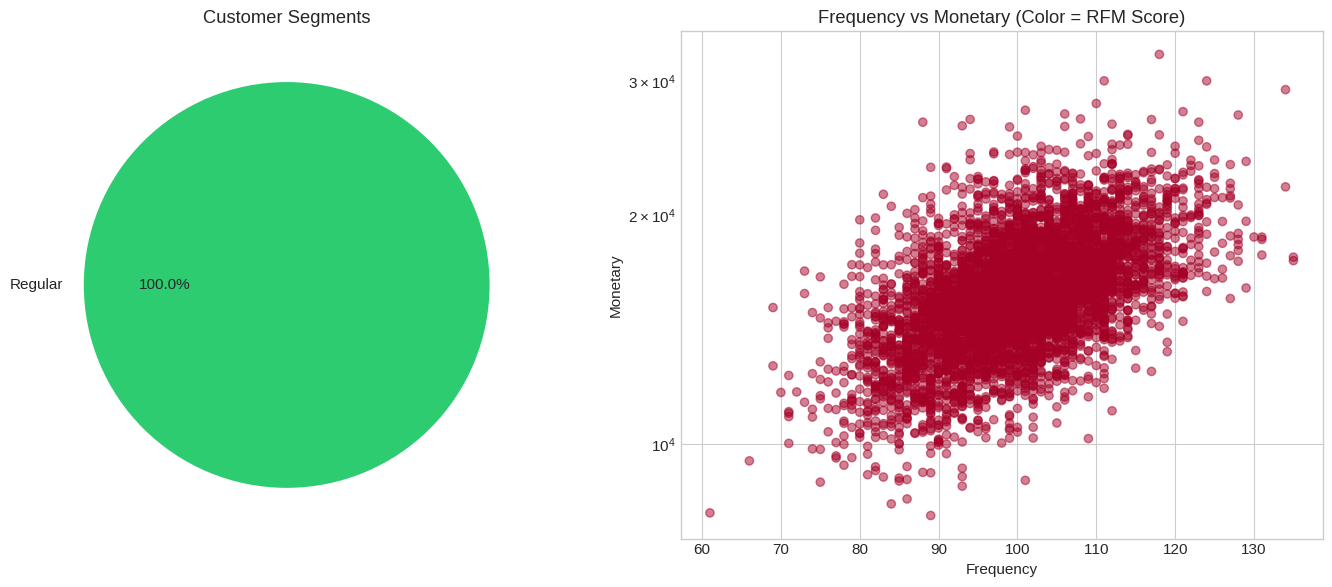

In [26]:
# =============================================================================
# 🏋️ EXERCISE 3.1: BUILD THE RFM PIPELINE
# =============================================================================
# Task: Perform a full RFM analysis on the GPU.
# =============================================================================

print("🏗️ BUILDING RFM PIPELINE")

if CUDF_AVAILABLE:
    # STEP 1: MOVE DATA TO GPU (ONCE!)
    print("1️⃣ Moving data to GPU...")
    start = time.time()
    gdf = cudf.DataFrame.from_pandas(df_pandas)
    print(f"   Done in {time.time()-start:.2f}s")

    # STEP 2: CALCULATE R, F, M VALUES
    print("\n2️⃣ Calculating R, F, M values...")
    # -------------------------------------------------------------------------
    # TODO: GroupBy 'customer_id' and calculate:
    # - max transaction_date (Recency)
    # - count transaction_id (Frequency)
    # - sum total_amount (Monetary)
    # -------------------------------------------------------------------------
    # Hint: Use .agg({'transaction_date': 'max', 'transaction_id': 'count', 'total_amount': 'sum'})

    rfm = gdf.groupby('customer_id').agg({
        "transaction_date": "max",
        "transaction_id":"count",
        "total_amount":"sum"
    })

    # Rename columns for clarity
    if rfm is not None:
        # ⚠️ CAUTION: Ensure your aggregation order matches the names below!
        # If you used the hint above, this order is correct.
        rfm.columns = ['last_date', 'frequency', 'monetary']

        # Calculate days since last purchase
        ref_date = pd.Timestamp('2024-11-27')
        rfm['recency'] = (ref_date - rfm['last_date']).dt.days

        print(f"   Calculated RFM for {len(rfm)} customers")
        print(rfm.head())

        # STEP 3: VISUALIZE
        print("\n3️⃣ Visualizing Segments...")
        # Simple scoring for viz
        rfm['RFM_score'] = (rfm['frequency'] > 5).astype(int) + (rfm['monetary'] > 1000).astype(int) * 10
        visualize_rfm_segments(rfm)

else:
    print("❌ cuDF not available")

### 3.2 Code Comparison: Pandas vs. cuDF

One of RAPIDS' greatest strengths is **API compatibility**. Let's see them side-by-side:

| Operation | Pandas (CPU) | cuDF (GPU) |
|-----------|-------------|------------|
| Import | `import pandas as pd` | `import cudf` |
| Read CSV | `pd.read_csv('file.csv')` | `cudf.read_csv('file.csv')` |
| From DataFrame | - | `cudf.DataFrame.from_pandas(df)` |
| GroupBy | `df.groupby('col').agg({...})` | `gdf.groupby('col').agg({...})` |
| Sort | `df.sort_values('col')` | `gdf.sort_values('col')` |
| Filter | `df[df['col'] > 5]` | `gdf[gdf['col'] > 5]` |
| To Pandas | - | `gdf.to_pandas()` |

**The takeaway:** If you know Pandas, you already know 90% of cuDF!

### 3.3 Best Practices for GPU-Accelerated Data Mining

**The Golden Rules:**

In [27]:
# =============================================================================
# CELL 3.3: BEST PRACTICES DEMONSTRATION
# =============================================================================
# This cell demonstrates common mistakes and best practices.
# =============================================================================

print("=" * 70)
print("BEST PRACTICES FOR GPU-ACCELERATED DATA MINING")
print("=" * 70)

# -----------------------------------------------------------------------------
# RULE 1: Keep data on GPU - Avoid unnecessary transfers
# -----------------------------------------------------------------------------

print("\n📌 RULE 1: KEEP DATA ON GPU")
print("-" * 50)

if CUDF_AVAILABLE:
    try:
        # BAD: Transfer back and forth for each operation
        print("\n❌ BAD PATTERN (frequent transfers):")

        gc.collect()
        start_bad = time.time()

        # Simulating bad pattern: transfer for each operation
        df_gpu = cudf.DataFrame.from_pandas(df_pandas[['customer_id', 'total_amount']].head(1_000_000))
        temp_pandas = df_gpu.to_pandas()  # Unnecessary transfer!
        temp_pandas['doubled'] = temp_pandas['total_amount'] * 2
        df_gpu = cudf.DataFrame.from_pandas(temp_pandas)  # Transfer back!
        temp_pandas = df_gpu.to_pandas()  # Transfer again!
        temp_pandas['tripled'] = temp_pandas['total_amount'] * 3

        bad_time = time.time() - start_bad
        print(f"   Time with unnecessary transfers: {bad_time:.3f} seconds")

        del df_gpu, temp_pandas
        gc.collect()

        # GOOD: Keep all operations on GPU
        print("\n✅ GOOD PATTERN (stay on GPU):")

        start_good = time.time()

        df_gpu = cudf.DataFrame.from_pandas(df_pandas[['customer_id', 'total_amount']].head(1_000_000))
        df_gpu['doubled'] = df_gpu['total_amount'] * 2  # Stays on GPU
        df_gpu['tripled'] = df_gpu['total_amount'] * 3  # Stays on GPU
        # Only transfer at the very end when you need results
        final_result = df_gpu.to_pandas()

        good_time = time.time() - start_good
        print(f"   Time with GPU-only operations: {good_time:.3f} seconds")
        print(f"   Improvement: {bad_time/good_time:.1f}x faster!")

        del df_gpu, final_result
        gc.collect()

    except Exception as e:
        print(f"\n   ❌ GPU demonstration failed: {type(e).__name__}")
        print("   GPU memory may be in an inconsistent state.")
        print("   Try: Runtime → Restart runtime")
        print("")
        print("   📖 EXPECTED RESULTS:")
        print("   ❌ BAD PATTERN:  ~0.5-1.0 seconds")
        print("   ✅ GOOD PATTERN: ~0.1-0.3 seconds")
        print("   Improvement: ~2-5x faster!")
else:
    print("\n   (cuDF not available - skipping GPU demonstration)")

# -----------------------------------------------------------------------------
# RULE 2: Use appropriate data types
# -----------------------------------------------------------------------------

print("\n📌 RULE 2: USE APPROPRIATE DATA TYPES")
print("-" * 50)
print("""
   ✅ Use int32 instead of int64 when possible (half the memory!)
   ✅ Use float32 instead of float64 for most ML tasks
   ✅ Use categorical types for string columns with few unique values

   Memory impact example:
   - 10M rows × int64: 80 MB
   - 10M rows × int32: 40 MB (50% reduction!)

   GPU memory is precious - optimize your dtypes!
""")

# -----------------------------------------------------------------------------
# RULE 3: Batch operations
# -----------------------------------------------------------------------------

print("\n📌 RULE 3: BATCH YOUR OPERATIONS")
print("-" * 50)
print("""
   ❌ BAD:  Running 1000 small queries one at a time
   ✅ GOOD: Combining into larger batch operations

   Each kernel launch has overhead. Minimize the number of operations!
""")

# -----------------------------------------------------------------------------
# RULE 4: Profile before optimizing
# -----------------------------------------------------------------------------

print("\n📌 RULE 4: PROFILE BEFORE OPTIMIZING")
print("-" * 50)
print("""
   Always measure before assuming GPU will be faster!

   Tools:
   - Python's time module (what we've been using)
   - cuDF's built-in profiler
   - NVIDIA Nsight Systems for detailed GPU profiling

   Questions to ask:
   - Is the dataset large enough? (< 100K rows: CPU might win)
   - What's the transfer time vs compute time ratio?
   - Are there operations cuDF doesn't accelerate well?
""")

# -----------------------------------------------------------------------------
# RULE 5: Handle memory carefully
# -----------------------------------------------------------------------------

print("\n📌 RULE 5: MANAGE GPU MEMORY")
print("-" * 50)

if NUMBA_AVAILABLE:
    try:
        free_mem, total_mem = cuda.current_context().get_memory_info()
        print(f"   Current GPU memory: {free_mem/1e9:.2f} GB free / {total_mem/1e9:.2f} GB total")
    except Exception as e:
        print(f"   (GPU memory query failed - may be in inconsistent state)")
    print("""
   Tips:
   - Delete DataFrames when no longer needed: del df_gpu
   - Call gc.collect() after deletions
   - Monitor memory with nvidia-smi
   - For very large datasets, process in chunks
""")

print("=" * 70)

BEST PRACTICES FOR GPU-ACCELERATED DATA MINING

📌 RULE 1: KEEP DATA ON GPU
--------------------------------------------------

❌ BAD PATTERN (frequent transfers):
   Time with unnecessary transfers: 0.093 seconds

✅ GOOD PATTERN (stay on GPU):
   Time with GPU-only operations: 0.081 seconds
   Improvement: 1.1x faster!

📌 RULE 2: USE APPROPRIATE DATA TYPES
--------------------------------------------------

   ✅ Use int32 instead of int64 when possible (half the memory!)
   ✅ Use float32 instead of float64 for most ML tasks
   ✅ Use categorical types for string columns with few unique values

   Memory impact example:
   - 10M rows × int64: 80 MB
   - 10M rows × int32: 40 MB (50% reduction!)

   GPU memory is precious - optimize your dtypes!


📌 RULE 3: BATCH YOUR OPERATIONS
--------------------------------------------------

   ❌ BAD:  Running 1000 small queries one at a time
   ✅ GOOD: Combining into larger batch operations

   Each kernel launch has overhead. Minimize the number of 

---

## 💀 Part 4: The Final Boss - The Impossible Travel Detector

### The Scenario
You are a Data Engineer at a global bank. You process millions of login events every hour.
Your security team has identified a new fraud pattern: **"Impossible Travelers"**.

These are hackers who:
1.  Log in to an account from **London** at 1:00 PM.
2.  Log in to the *same* account from **New York** at 2:00 PM.

**The Problem:** The distance between London and New York is ~5,500 km. No plane flies that fast (Mach 4+). This is physically impossible and indicates a shared credential attack.

### The Challenge
You have a dataset of 1 million logins with `latitude`, `longitude`, and `timestamp`.
You must identify all users who moved faster than **800 km/h** (approximate plane speed).

**Why this is hard:**
- You need to compare row $i$ with row $i-1$ (sequential dependency).
- You need to calculate the **Haversine Distance** (complex trigonometry) for every pair.
- SQL and Pandas are slow at "row vs previous row" logic on millions of groups.
- **Solution:** A custom CUDA kernel!

### 4.1 Generate Data
First, let's generate a dataset with some injected fraud cases.

In [ ]:
# =============================================================================
# CELL 4.1: GENERATE TRAVEL DATA
# =============================================================================
# We need a dataset with locations (lat/lon) and timestamps.
# =============================================================================

print("🌍 Generating Travel Data...")

# 1. Create a focused dataset for this challenge
# We'll use 1 million logins to keep it manageable but significant
n_logins = 1_000_000
n_users = 50_000

# Generate base data
logins = pd.DataFrame({
    'user_id': np.random.randint(1, n_users + 1, size=n_logins, dtype=np.int32),
    'timestamp': pd.Timestamp('2024-01-01') + pd.to_timedelta(np.random.randint(0, 60*24*30, size=n_logins), unit='min')
})

# Generate locations (approximate UK/US coordinates for realism)
# Most users are in UK (50-55 lat, -5 to 2 lon)
lat_uk = np.random.uniform(50, 55, size=n_logins)
lon_uk = np.random.uniform(-5, 2, size=n_logins)

# Some users are in US (30-45 lat, -120 to -70 lon)
lat_us = np.random.uniform(30, 45, size=n_logins)
lon_us = np.random.uniform(-120, -70, size=n_logins)

# Assign 90% to UK, 10% to US
mask = np.random.random(n_logins) > 0.9
logins['latitude'] = np.where(mask, lat_us, lat_uk).astype(np.float32)
logins['longitude'] = np.where(mask, lon_us, lon_uk).astype(np.float32)

# INJECT FRAUD: Create "Impossible Travelers"
# Pick 100 random users and force a UK -> US jump in 1 hour
# We append specific fraud pairs to ensure they exist
fraud_cases = pd.DataFrame({
    'user_id': np.random.randint(90000, 99999, size=50), # Special IDs
    'timestamp': [pd.Timestamp('2024-01-01 12:00:00')] * 50,
    'latitude': [51.5074] * 50, # London
    'longitude': [-0.1278] * 50
})
fraud_cases_jump = fraud_cases.copy()
fraud_cases_jump['timestamp'] = fraud_cases['timestamp'] + pd.Timedelta(hours=2)
fraud_cases_jump['latitude'] = 40.7128 # NYC
fraud_cases_jump['longitude'] = -74.0060

# Combine and shuffle
logins = pd.concat([logins, fraud_cases, fraud_cases_jump]).sample(frac=1).reset_index(drop=True)

print(f"✅ Generated {len(logins)} login events.")
print(logins.head())

### 4.2 The Challenge (Numba Kernel)

**The Logic:**
1.  **Sort** the data by `user_id` and `timestamp`. This places consecutive events for the same user next to each other in memory.
2.  **Launch** one thread per row.
3.  **Check**: If `user_id[i] == user_id[i-1]`, calculate the distance and time difference.
4.  **Flag**: If speed > 800 km/h, mark as suspicious.

**The Math (Haversine Formula):**
$$ a = \sin^2(\frac{\Delta\phi}{2}) + \cos \phi_1 \cdot \cos \phi_2 \cdot \sin^2(\frac{\Delta\lambda}{2}) $$
$$ c = 2 \cdot \text{atan2}(\sqrt{a}, \sqrt{1-a}) $$
$$ d = R \cdot c $$
Where $\phi$ is latitude, $\lambda$ is longitude, $R$ is earth radius (6371 km).
All angles must be in **radians**.

In [ ]:
# =============================================================================
# 🏋️ EXERCISE 4.2: THE IMPOSSIBLE TRAVEL DETECTOR
# =============================================================================
# YOUR MISSION: Write a kernel to detect impossible travel speeds.
# =============================================================================

if CUDF_AVAILABLE and NUMBA_AVAILABLE:
    from math import sin, cos, sqrt, atan2, radians

    # 1. PREPARE DATA
    print("1️⃣ Moving and Sorting Data...")
    gdf_logins = cudf.DataFrame.from_pandas(logins)

    # TODO: Sort by 'user_id' and 'timestamp'
    # gdf_logins = ...

    # Convert timestamp to seconds for the kernel
    gdf_logins['time_sec'] = gdf_logins['timestamp'].astype('int64') // 10**9

    # 2. DEFINE THE KERNEL
    @cuda.jit
    def impossible_travel_kernel(lat, lon, time, user_id, suspicious_flags):
        i = cuda.grid(1)

        if i > 0 and i < lat.size:
            # -----------------------------------------------------------------
            # TODO 1: Check if current row 'i' is same user as 'i-1'
            # -----------------------------------------------------------------

            # -----------------------------------------------------------------
            # TODO 2: Calculate Time Difference (in hours)
            # -----------------------------------------------------------------

            # -----------------------------------------------------------------
            # TODO 3: Calculate Haversine Distance (km)
            # Formula:
            # a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
            # c = 2 ⋅ atan2( √a, √(1−a) )
            # d = R ⋅ c
            # (Use radians, sin, etc. from the imports above)
            # -----------------------------------------------------------------

            # -----------------------------------------------------------------
            # TODO 4: Calculate Speed & Flag if > 800 km/h
            # -----------------------------------------------------------------
            pass

    # 3. LAUNCH
    print("2️⃣ Launching Kernel...")
    suspicious = cudf.Series(np.zeros(len(gdf_logins), dtype=np.int32))

    # TODO: Configure Grid
    # threads = ...
    # blocks = ...

    # TODO: Launch Kernel
    # impossible_travel_kernel[...](...)

    # 4. REPORT
    gdf_logins['suspicious'] = suspicious
    print(f"\n🚨 Found {gdf_logins['suspicious'].sum()} suspicious events.")

else:
    print("❌ GPU libraries not available")

---

## 🧹 Cleanup & Memory Management

Always clean up GPU resources when done to prevent memory leaks!

In [ ]:
# =============================================================================
# CLEANUP CELL
# =============================================================================
# Run this cell to free GPU memory when you're done experimenting.
# =============================================================================

print("🧹 Cleaning up GPU memory...")

# Delete GPU DataFrames if they exist
# Using globals() is more reliable than dir() for this purpose
gpu_vars = [
    'df_cudf', 'df_sorted_gpu', 'res_gpu', 'products_gpu', 'merged_gpu',
    'gdf', 'rfm', 'gdf_demo', 'd_data', 'a', 'b', 'c', 'A', 'B', 'C', 'img_gpu'
]

for var in gpu_vars:
    if var in globals():
        del globals()[var]
        print(f"   Deleted {var}")

# Force garbage collection
gc.collect()

# Clear CUDA memory cache
if NUMBA_AVAILABLE:
    try:
        cuda.current_context().memory_manager.deallocations.clear()
    except:
        pass  # May fail if no allocations to clear

# Report final memory state
if NUMBA_AVAILABLE:
    try:
        free_mem, total_mem = cuda.current_context().get_memory_info()
        print(f"\n   GPU Memory: {free_mem/1e9:.2f} GB free / {total_mem/1e9:.2f} GB total")
    except (NotImplementedError, Exception):
        # RMM allocator doesn't support get_memory_info()
        print("\n   (GPU memory info not available with RMM allocator)")

print("\n✅ Cleanup complete!")

---

## 📚 Workshop Summary

### 🏋️ Exercises Completed

| Exercise | Topic | Skills Practiced |
|----------|-------|------------------|
| **Exercise 1** | RAPIDS (cuDF) | Sorting, GroupBy, Joins on GPU |
| **Exercise 2.3** | Vector Addition Kernel | Thread indexing, bounds checking, 1D grids |
| **Exercise 2.5** | Matrix Multiplication | 2D grids, dot product, 2D bounds |
| **Exercise 3.1** | RFM Pipeline | End-to-end GPU data mining workflow |
| **Exercise 4.2** | Impossible Travel | Custom Kernels, Haversine, Sequential Logic |

### What We Covered

| Part | Topic | Key Takeaway |
|------|-------|--------------|
| **Part 1** | Benchmarking | GPU can be 10-50x faster for large datasets |
| **Part 2** | CUDA Fundamentals | Grid → Block → Thread hierarchy; memory management is critical |
| **Part 3** | Data Mining Workflow | cuDF provides Pandas-like API with GPU acceleration |
| **Part 4** | Advanced Kernels | Solving complex logic (row-wise dependencies) with Numba |

### The GPU Computing Stack

```
┌─────────────────────────────────────────────────────────────────────┐
│  YOUR CODE                                                          │
│  └── When to use: Always start here!                               │
├─────────────────────────────────────────────────────────────────────┤
│  RAPIDS (cuDF, cuML, cuGraph)                                       │
│  └── When to use: 90% of data mining tasks                         │
│  └── Pandas/Scikit-learn-like APIs                                 │
├─────────────────────────────────────────────────────────────────────┤
│  Numba CUDA                                                         │
│  └── When to use: Custom operations not in RAPIDS                  │
│  └── Write Python, runs on GPU                                     │
├─────────────────────────────────────────────────────────────────────┤
│  Raw CUDA (C/C++)                                                   │
│  └── When to use: Maximum performance, library development         │
│  └── Rarely needed for data mining                                 │
└─────────────────────────────────────────────────────────────────────┘
```

### Common Student Mistakes Checklist

- [ ] ❌ Forgot to enable GPU runtime (Runtime → Change runtime type → T4 GPU)
- [ ] ❌ Didn't restart runtime after installing cuDF
- [ ] ❌ Transferring data between CPU/GPU too frequently
- [ ] ❌ Using int64/float64 when int32/float32 would suffice
- [ ] ❌ Not including bounds checking in custom kernels
- [ ] ❌ Expecting GPU speedup on small datasets (< 100K rows)
- [ ] ❌ Forgetting cuda.synchronize() when timing GPU operations

### Next Steps

1. **Practice:** Modify this notebook with your own datasets
2. **Explore:** Check out cuML for GPU-accelerated machine learning
3. **Read:** RAPIDS documentation at https://docs.rapids.ai/
4. **Experiment:** Try different block sizes and measure performance

---

## 📝 Additional Exercises (Take-Home)

1. **Modify the data size:** Change `N_ROWS` to 5M and 20M. How does speedup change?
2. **New benchmark:** Add a filtering benchmark (e.g., `df[df['total_amount'] > 100]`)
3. **Advanced kernel:** Write a kernel that computes `sqrt(a^2 + b^2)` for two vectors
4. **Real data:** Download a large CSV from Kaggle and compare loading times

---

**📌 STUDENT VERSION** - Compare with instructor notebook for complete solutions!

*Questions? Raise your hand or post in the course forum!*
*Questions? Raise your hand or post in the course forum!**Questions? Raise your hand or post in the course forum!*